In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [5]:
llm.invoke("hi hello how are you?")

AIMessage(content="Hello! I'm here to help. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 13, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BntMTwl2SszK7PL8dKO6X2u5sO2uA', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--7a37cd7b-6de0-4d70-8d5a-6c4e70db8447-0', usage_metadata={'input_tokens': 13, 'output_tokens': 14, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
from langgraph.types import Command

In [7]:
from langgraph.prebuilt import create_react_agent

Example usage of Command

In [8]:
def add_number(state):
    result=state["num1"]+state["num2"]
    print(f"addition is {result}")
    return Command(goto="multiply",update={"sum":result})

In [9]:
state={"num1":10,"num2":20}

In [10]:
add_number(state)

addition is 30


Command(update={'sum': 30}, goto='multiply')

### Creating one dummy multiagent

For network/collab multiagent

In [11]:
from langchain_core.tools import tool

In [12]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return

In [13]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return

In [14]:
llm_with_tool=llm.bind_tools([transfer_to_addition_expert])

In [15]:
response=llm_with_tool.invoke("hi")

In [16]:
response.content

'Hello! How can I assist you today?'

In [17]:
response.tool_calls

[]

In [18]:
response=llm_with_tool.invoke("what is 2+2?")

In [19]:
response.content

''

In [20]:
response.tool_calls

[{'name': 'transfer_to_addition_expert',
  'args': {},
  'id': 'call_yTnpXHZH36LgUCOSEp0icgtM',
  'type': 'tool_call'}]

In [21]:
system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )

In [22]:
messages = [{"role": "system", "content": system_prompt}] + ["can you tell me the addition of 2 and 2?"]

In [23]:
messages

[{'role': 'system',
  'content': 'You are an addition expert, you can ask the multiplication expert for help with multiplication.Always do your portion of calculation before the handoff.'},
 'can you tell me the addition of 2 and 2?']

In [24]:
from typing_extensions import Literal
from langgraph.graph import MessagesState,StateGraph, START,END

In [ ]:
## Agent 1
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        # Meta information (can be changed as per developer) - dummy information
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [26]:
## Agent2
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [27]:
graph=StateGraph(MessagesState)

In [28]:
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)

In [29]:
graph.add_edge(START, "additional_expert")

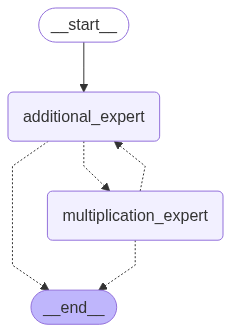

In [30]:
graph.compile()

In [31]:
app=graph.compile()

In [32]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='c79ccb36-82b4-4d7e-9058-7be62041206d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZdWXcbG2UBrHzxBYnskMiaxv', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 86, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BnuIaj8iPz4jF205ZVPJwwCmq6CBC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5a51b766-f2e4-425c-bc87-57147ea6e084-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 

### With realtime tool

In [61]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [62]:
from langchain_experimental.utilities import PythonREPL

In [63]:
repl=PythonREPL()

In [64]:
code = """
x = 5
y = x * 2
print(y)
"""

In [65]:
repl.run(code)

'10\n'

In [66]:
from typing import Annotated

In [82]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with 'print(...)'. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\'\'\'python\n{code}\n\'\'\'\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [83]:
python_repl_tool

StructuredTool(name='python_repl_tool', description="Use this to execute python code. If you want to see the output of a value,\nyou should print it out with 'print(...)'. This is visible to the user.", args_schema=<class 'langchain_core.utils.pydantic.python_repl_tool'>, func=<function python_repl_tool at 0x00000148577E76A0>)

In [84]:
print(python_repl_tool.invoke(code))

Successfully executed:
'''python

x = 5
y = x * 2
print(y)

'''
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.


In [85]:
print(python_repl_tool.invoke(code))

Successfully executed:
'''python

x = 5
y = x * 2
print(y)

'''
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.


In [86]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [87]:
make_system_prompt("You can only do research. You are working with a chart generator colleague.")

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [88]:
from langchain_core.messages import BaseMessage, HumanMessage

In [89]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [ ]:
#agent1
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    research_agent=create_react_agent(
        llm,
        tools=[search_tool],
        prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ), 
        )
    
    result=research_agent.invoke(state)
    
    '''result=[messages:{humanmesssage
                    aimessgae
                    toolmessage
                    aimessage
                    toolmessage
                    aimessage}]'''
    
    goto=get_next_node(result["messages"][-1],"chart_generator")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]},goto=goto)

agent1(human1)-->agent2(human2)

In [91]:
#agent2
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    chart_agent=create_react_agent(
        llm,
        tools=[python_repl_tool],
        prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
        )
    result=chart_agent.invoke(state)
    goto=get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    return Command(update={"messages": result["messages"]},goto=goto)

In [92]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

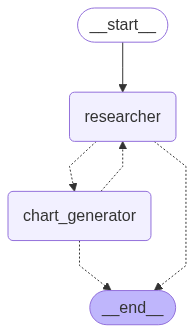

In [93]:
workflow.compile()

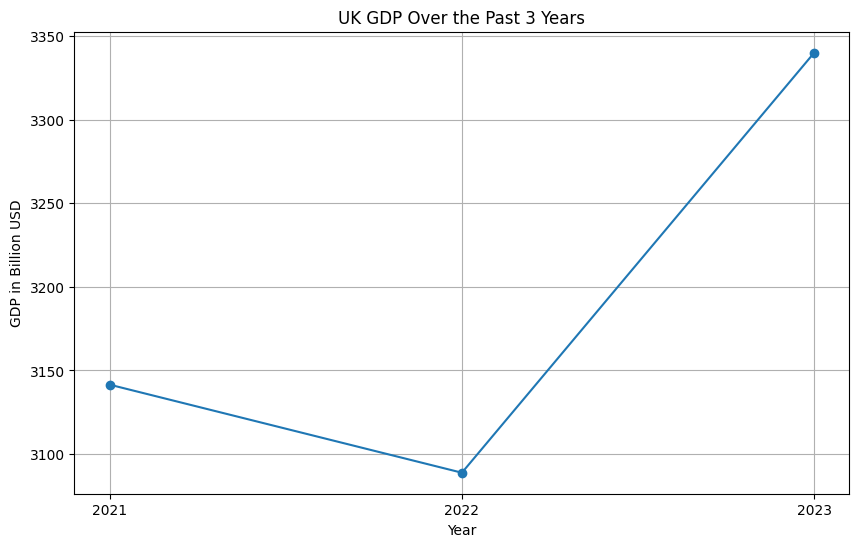

{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='86cd8799-7ce3-4802-bd3f-7795a6b53ff8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2nDyrIOur3Lf6NG0bOuYNOOy', 'function': {'arguments': '{"query": "UK GDP 2021"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_AP3W8DKTuROSC5rZBwX1WxVM', 'function': {'arguments': '{"query": "UK GDP 2022"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_WQtYqjtyzSJkQYaLh6ksz9qY', 'function': {'arguments': '{"query": "UK GDP 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 205, 'total_tokens': 287, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_toke

In [95]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})